# Patient Monitoring and Decision Support using Health Data

**Notebook by Olivier Nguyen (Github: [olinguyen](http://github.com/olinguyen))**

The main objective of this notebook is to explore and introduce working with the MIMIC database using various tools.

## MIMIC Database

The MIMIC database, short for Medical Information Mart For Intensive Care, is a database that holds a large amount of information relating to patients admitted to the intensive care unit (ICU) at a large care hospital. The dataset contains contains clinical data (demographics, diagnoses, laboratory values), time-stamped nurse-verified physiological measurements, documented progress notes by care providers, and much more. This rich information that is available allows to research, develop and evaluate intensive care unit (ICU) patient monitoring and decision support systems that have the potential to improve the efficiency and timeliness of clinical decision-making in critical care.

Because of the large size of data, it is loaded in a database system like PostgreSQL to better manage and handle the high quantity of information. Before we dive into any machine learning or data analysis, we'll first explore the contents of the dataset using SQL and different Python libraries for visualization and analysis. More specifically, we'll cover the following in this notebook:

* How to select data from a database using Structured Query Language (SQL)
* Query basic demographics from the MIMIC database
* Plot histograms displaying patient information
* Create descriptive statistics describing the demographics of the dataset
* Extract vital signs and laboratory measurements for a single patient

## Pre-requisites

Although access to the database is freely available to researchers around the world, a Human Subjects training is required to handle sensitive patient information. More details for the formal request can be found in the following  [link](https://mimic.physionet.org/gettingstarted/access/).

The following code will assume a prior installation of the MIMIC database in a local Postgres database. The installation procedure can be followed [here](https://mimic.physionet.org/tutorials/install-mimic-locally-ubuntu/).

A tutorial introducing basic SQL concepts with the MIMIC-III database can also be found [here](https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/sql-intro.md).



## Exploring the MIMIC database

Since MIMIC is a relational database containing tables of patient data who stayed at the ICU, data will be extracted using SQL queries and then stored as Pandas dataframes for easy manipulation. After setting up the Postgres database, we'll use the `psycopg2` library to connect to the the SQL database for queries. 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline

plt.style.use('ggplot')

In [4]:
# SQL database config
sqluser = ''
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = ''
port = 5432
pwd = getpass.getpass()

········


In [5]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

A more complete description of the entire MIMIC database can be found [here](mimic.physionet.org/gettingstarted/overview), but a quick overview is given below.

The tables are linked by identifiers with the suffix `ID`: `SUBJECT_ID` which represents a unique patient, `HADM_ID` which represents a unique patient hospital stay and `ICUSTAY_ID` which represents a unique patient ICU stay.

The following tables are used to define and track patient stays:

* `ADMISSIONS`: Every unique hospitalization for each patient in the database (defines HADM_ID)
* `CALLOUT`: Information regarding when a patient was cleared for ICU discharge and when the patient was actually discharged
* `ICUSTAYS`: Every unique ICU stay in the database (defines ICUSTAY_ID)
* `PATIENTS`: Every unique patient in the database (defines SUBJECT_ID)
* `SERVICES`: The clinical service under which a patient is registered
* `TRANSFERS`: Patient movement from bed to bed within the hospital, including ICU admission and discharge

A simple SQL query can therefore be used as follows, which would select only female subjects from the database, or patients with the subject_id 109 or 127.

```sql
SELECT *
FROM patients
WHERE subject_id = 109
OR subject_id = 127;
OR gender = 'F'
```

## Joining admissions, icustays, and patients tables

We'll now combine multiple tables in order obtain a more detailed description of the data. In particular, we'll extract the following columns that contain basic information regarding the patients in the database:

* Identifiers (subject_id, hadm_id, icustay_id)
* The ICU care unit 
* The patients date of birth, death
* The time the patient entered and left the ICU
* The length of stay at the hospital
* The age during the ICU and the hospital stay
* Whether the patient died in the ICU or in the hospital

In [6]:
query = \
"""
WITH population as (
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
FROM admissions a
INNER JOIN icustays i
ON a.hadm_id = i.hadm_id
INNER JOIN patients p
ON a.subject_id = p.subject_id
ORDER BY a.subject_id, i.intime
)
SELECT *
FROM population
WHERE age_hosp_in >= 16;
"""

query_output = pd.read_sql_query(query,con)
query_output.head()

,subject_id,hadm_id,icustay_id,hosp_admittime,hosp_dischtime,first_careunit,icu_seq,dob,dod,icu_intime,icu_outtime,icu_los,hosp_los,gender,age_hosp_in,age_icu_in,hospital_expire_flag,icu_expire_flag
0,3,145834,211552,2101-10-20 19:08:00,2101-10-31 13:58:00,MICU,1,2025-04-11,2102-06-14,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,10.7847,M,76.5268,76.5268,0,0
1,4,185777,294638,2191-03-16 00:28:00,2191-03-23 18:41:00,MICU,1,2143-05-12,NaT,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,7.7590,F,47.8450,47.8450,0,0
2,6,107064,228232,2175-05-30 07:15:00,2175-06-15 16:00:00,SICU,1,2109-06-21,NaT,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,16.3646,F,65.9407,65.9423,0,0
3,9,150750,220597,2149-11-09 13:06:00,2149-11-14 10:15:00,MICU,1,2108-01-26,2149-11-14,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,4.8813,M,41.7902,41.7902,1,1
4,11,194540,229441,2178-04-16 06:18:00,2178-05-11 19:00:00,SICU,1,2128-02-22,2178-11-14,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,25.5292,F,50.1483,50.1483,0,0


Using the above columns, we can compute the following points for general statistics of the dataset:

* Hospital admissions, no. (% of total admissions)
* Distinct ICU stays, no. (% of total unit stays)
* Age, yrs, mean ± SD 
* Gender, male, percent of unit stays
* ICU length of stay, median days (IQR)
* Hospital length of stay, median days (IQR)
* ICU mortality, percent of unit stays
* Hospital mortality, percent of unit stays

Note: the dates may seem futuristic e.g. born in 2191, but they are presented that way to protect patient privacy. Age and length of stay can still be computed from these dates.

In [7]:
len(query_output)

53423

In [6]:
distinct_patients = len(query_output.subject_id.unique())
hospital_admissions = len(query_output.hadm_id.unique())
distinct_icu_stay = len(query_output.icustay_id.unique())
age = query_output.age_icu_in.median()
gender = (query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count() \
     / query_output.loc[query_output.icu_seq==1].gender.count()*100)['M']
icu_los = query_output.icu_los.median()
hospital_los = query_output.hosp_los.median()
icu_mortality = query_output.icu_expire_flag.sum() / float(query_output.icu_expire_flag.count()) * 100
hospital_mortality = (query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count() \
    / query_output.drop_duplicates(['hadm_id']).hospital_expire_flag.count()*100)[1]


df1 = pd.DataFrame({'Distinct patients': [distinct_patients],
                    'Hospital admissions': [hospital_admissions],
                    'Distinct ICU stays': [distinct_icu_stay],
                    'Age, years, median': [age],
                    'Gender, male, % unit stays': [gender],
                    'ICU length of stay (days)': [icu_los],
                    'Hospital length of stay (days)': [hospital_los],
                    'ICU mortality (%)': [icu_mortality],
                    'Hospital mortality (%)': [hospital_mortality],    
                   })
df1

,"Age, years, median",Distinct ICU stays,Distinct patients,"Gender, male, % unit stays",Hospital admissions,Hospital length of stay (days),Hospital mortality (%),ICU length of stay (days),ICU mortality (%)
0,65.769,53423,38597,56.207693,49785,7.309,11.545646,2.14425,8.545009


In [8]:
query_output.columns

Index([u'subject_id', u'hadm_id', u'icustay_id', u'hosp_admittime',
       u'hosp_dischtime', u'first_careunit', u'icu_seq', u'dob', u'dod',
       u'icu_intime', u'icu_outtime', u'icu_los', u'hosp_los', u'gender',
       u'age_hosp_in', u'age_icu_in', u'hospital_expire_flag',
       u'icu_expire_flag'],
      dtype='object')

Let's now plot some basic demographic information to better visualize the patients

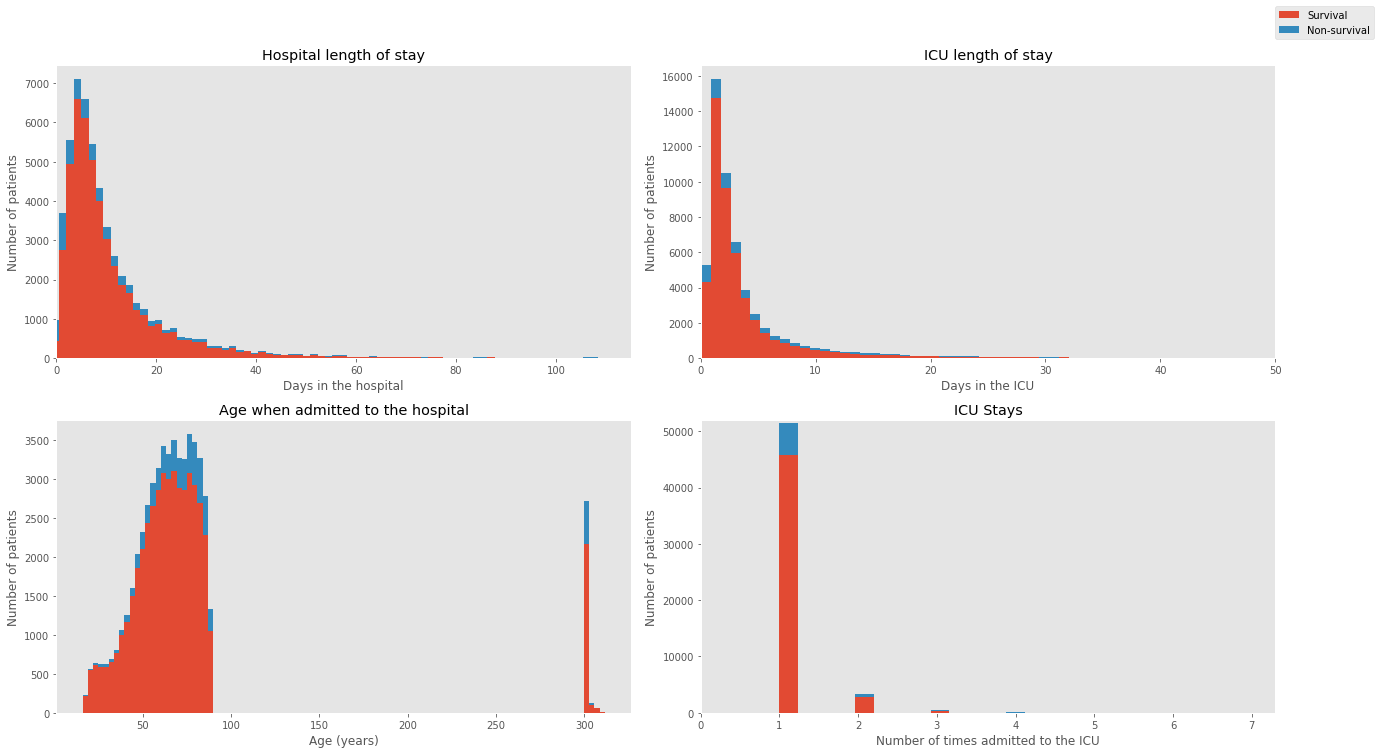

In [38]:
died = query_output[query_output.hospital_expire_flag == 1]
survived = query_output[query_output.icu_expire_flag == 0]

f, axarr = plt.subplots(2, 2, figsize=(18, 10))

p0 = axarr[0, 0].hist([survived['hosp_los'].dropna(), died['hosp_los'].dropna()], stacked=True, bins=200, normed=False)
axarr[0, 0].set_xlabel('Days in the hospital')
axarr[0, 0].set_ylabel('Number of patients')
axarr[0, 0].set_title('Hospital length of stay')
axarr[0, 0].set_xlim(0, 115)
axarr[0, 0].grid(b=False)
#axarr[0, 0].legend(loc='upper right')

p1 = axarr[0, 1].hist([survived['icu_los'].dropna(), died['icu_los'].dropna()], stacked=True, bins=200, normed=False)
axarr[0, 1].set_xlabel('Days in the ICU')
axarr[0, 1].set_ylabel('Number of patients')
axarr[0, 1].set_title('ICU length of stay')
axarr[0, 1].set_xlim(0, 50)
axarr[0, 1].grid(b=False)

p2 = axarr[1, 0].hist([survived['age_hosp_in'].dropna(), died['age_hosp_in'].dropna()], stacked=True, bins=100, normed=False)
axarr[1, 0].set_xlabel('Age (years)')
axarr[1, 0].set_ylabel('Number of patients')
axarr[1, 0].set_title('Age when admitted to the hospital')
axarr[1, 0].grid(b=False)

p3 = axarr[1, 1].hist([survived['icu_seq'].dropna(), died['icu_seq'].dropna()], stacked=True, bins=25, normed=False)
axarr[1, 1].set_xlabel('Number of times admitted to the ICU')
axarr[1, 1].set_ylabel('Number of patients')
axarr[1, 1].set_title('ICU Stays')
axarr[1, 1].set_ylim(0, 52000)
axarr[1, 1].set_xlim(0)
axarr[1, 1].grid(b=False)

axarr[1, 1].legend(['Survival', 'Non-survival'], loc=(1, 2.3))

plt.tight_layout()
plt.show()

## Distinct patients, no. (% of total admissions)

In [118]:
print('\nTotal number patients: {}'.format(len(query_output.subject_id.unique())))

print('\nNumber of patients by first careunit:\n')
distinctpatients_df = query_output[['first_careunit','subject_id']] \
                    .drop_duplicates(['subject_id']) \
                    .groupby('first_careunit').count()
print(distinctpatients_df)
    
print('\nProportion of total hospital admissions:\n')
print(query_output[['first_careunit','subject_id']] \
                    .drop_duplicates(['subject_id']) \
                    .groupby('first_careunit')
                    .count()/len(query_output.subject_id.unique())*100)


Total number patients: 38597

Number of patients by first careunit:

                subject_id
first_careunit            
CCU                   5674
CSRU                  7611
MICU                 13649
SICU                  6372
TSICU                 5291

Proportion of total hospital admissions:

                subject_id
first_careunit            
CCU              14.700624
CSRU             19.719149
MICU             35.362852
SICU             16.509055
TSICU            13.708319


## Hospital admissions, no. (% of total admissions)

In [122]:
print('\nTotal hospital admissions: {}'\
    .format(len(query_output.hadm_id.unique())))

print('\nNumber of hospital admissions by first careunit:\n')

hospitaladmissions_df = query_output[['first_careunit','hadm_id']] \
                    .drop_duplicates(['hadm_id']) \
                    .groupby('first_careunit').count()
        
print(hospitaladmissions_df)
    
print('\nProportion of total hospital admissions:\n')
print(query_output[['first_careunit','hadm_id']] \
                    .drop_duplicates(['hadm_id']) \
                    .groupby('first_careunit') \
                    .count()/len(query_output.hadm_id.unique())*100)


Total hospital admissions: 49785

Number of hospital admissions by first careunit:

                hadm_id
first_careunit         
CCU                7258
CSRU               8640
MICU              19770
SICU               8110
TSICU              6007

Proportion of total hospital admissions:

                  hadm_id
first_careunit           
CCU             14.578688
CSRU            17.354625
MICU            39.710756
SICU            16.290047
TSICU           12.065883


## Distinct ICU stays, no. (% of total unit stays)

In [11]:
print('\nTotal ICU stays: {}'\
    .format(len(query_output.icustay_id.unique())))

print('\nNumber of ICU stays by careunit:\n')
print(query_output[['first_careunit','icustay_id']] \
          .groupby('first_careunit').count())

print('\nProportion of total ICU stays:\n')
print(query_output[['first_careunit','icustay_id']] \
          .groupby('first_careunit') \
          .count()/len(query_output.icustay_id.unique())*100)


Total ICU stays: 53423

Number of ICU stays by careunit:

                icustay_id
first_careunit            
CCU                   7726
CSRU                  9311
MICU                 21087
SICU                  8891
TSICU                 6408

Proportion of total ICU stays:

                icustay_id
first_careunit            
CCU              14.461936
CSRU             17.428823
MICU             39.471763
SICU             16.642645
TSICU            11.994834


## Age, yrs, median ± IQR

We will report the median IQR for the age, since patients aged 90 and older appear with value 300.

In [12]:
print('Median age, years: {} '.format(query_output.age_icu_in.median()))
print('Lower quartile age, years: {} '.format(query_output.age_icu_in.quantile(0.25)))
print('Upper quartile age, years: {} \n '.format(query_output.age_icu_in.quantile(0.75)))

print('Median age by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').median())

print('\nLower quartile by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').quantile(0.25))

print('\nUpper quartile by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').quantile(0.75))

Median age, years: 65.769 
Lower quartile age, years: 52.8361 
Upper quartile age, years: 77.80005 
 
Median age by careunit, years:
 
                age_icu_in
first_careunit            
CCU                70.5697
CSRU               67.9286
MICU               64.9124
SICU               63.5819
TSICU              59.6125

Lower quartile by careunit, years:
 
                age_icu_in
first_careunit            
CCU               58.44555
CSRU              58.32150
MICU              51.65590
SICU              51.44315
TSICU             42.45665

Upper quartile by careunit, years:
 
                age_icu_in
first_careunit            
CCU              80.541375
CSRU             76.727250
MICU             78.170950
SICU             76.457500
TSICU            75.601550


## Gender, percent of unit stays

In [149]:
print('Gender:\n')
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count())
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count() \
     /query_output.loc[query_output.icu_seq==1].gender.count()*100)

print('Gender by careunit:\n')
print(query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit','gender']).gender.count())

print('\nProportion by unit:\n')
print(query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit','gender']) \
    .gender.count()/query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit']).gender.count()*100)

Gender:

gender
F    21802
M    27983
Name: gender, dtype: int64
gender
F    43.792307
M    56.207693
Name: gender, dtype: float64
Gender by careunit:

first_careunit  gender
CCU             F          3055
                M          4203
CSRU            F          2963
                M          5677
MICU            F          9577
                M         10193
SICU            F          3859
                M          4251
TSICU           F          2348
                M          3659
Name: gender, dtype: int64

Proportion by unit:

first_careunit  gender
CCU             F         42.091485
                M         57.908515
CSRU            F         34.293981
                M         65.706019
MICU            F         48.442084
                M         51.557916
SICU            F         47.583231
                M         52.416769
TSICU           F         39.087731
                M         60.912269
Name: gender, dtype: float64


In [ ]:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## ICU length of stay, median days

In [14]:
print('Median ICU length of stay, days: {}'.format(query_output.icu_los.median()))

print('Median length of ICU stay by careunit, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').median())

Median ICU length of stay, days: 2.14425
Median length of ICU stay by careunit, days:
 
                icu_los
first_careunit         
CCU             2.19775
CSRU            2.15295
MICU            2.09560
SICU            2.25220
TSICU           2.11260


## ICU mortality, percent of unit stays

In [15]:
print('ICU mortality, number:\n')
print(query_output \
    .groupby(['icu_expire_flag']) \
    .icu_expire_flag.count())

print('\nICU mortality, %:\n')
print(query_output.groupby(['icu_expire_flag']) \
    .icu_expire_flag.count() / query_output.icu_expire_flag.count()*100)

print('\nICU mortality by careunit:\n')
print(query_output \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count())

print('\nProportion by unit:\n')
print(query_output \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count()/query_output \
    .groupby(['first_careunit']).icu_expire_flag.count()*100)

ICU mortality, number:

icu_expire_flag
0    48858
1     4565
Name: icu_expire_flag, dtype: int64

ICU mortality, %:

icu_expire_flag
0    91.454991
1     8.545009
Name: icu_expire_flag, dtype: float64

ICU mortality by careunit:

first_careunit  icu_expire_flag
CCU             0                   7041
                1                    685
CSRU            0                   9010
                1                    301
MICU            0                  18865
                1                   2222
SICU            0                   8078
                1                    813
TSICU           0                   5864
                1                    544
Name: icu_expire_flag, dtype: int64

Proportion by unit:

first_careunit  icu_expire_flag
CCU             0                  91.133834
                1                   8.866166
CSRU            0                  96.767265
                1                   3.232735
MICU            0                  89.462702
            

## Hospital mortality, percent unit of stays

In [165]:
# NB: hadm_id is repeated in data due to multiple ICU stays
# ...so need to drop duplicates
print('Hospital mortality, number:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count())

print('\nHospital mortality, %:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count() \
    / query_output.drop_duplicates(['hadm_id']).hospital_expire_flag.count()*100)

print('\nHospital mortality:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit','hospital_expire_flag']) \
    .hospital_expire_flag.count())

print('\nProportion by unit:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit','hospital_expire_flag']) \
    .hospital_expire_flag.count()/query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit']).hospital_expire_flag.count()*100)

Hospital mortality, number:

hospital_expire_flag
0    44037
1     5748
Name: hospital_expire_flag, dtype: int64

Hospital mortality, %:

hospital_expire_flag
0    88.454354
1    11.545646
Name: hospital_expire_flag, dtype: float64

Hospital mortality:

first_careunit  hospital_expire_flag
CCU             0                        6441
                1                         817
CSRU            0                        8277
                1                         363
MICU            0                       16911
                1                        2859
SICU            0                        7090
                1                        1020
TSICU           0                        5318
                1                         689
Name: hospital_expire_flag, dtype: int64

Proportion by unit:

first_careunit  hospital_expire_flag
CCU             0                       88.743455
                1                       11.256545
CSRU            0                       95.798611

## Patient characteristics

Let's first see how many charted observations are available for each hospitalization. To do so, we'll use the `CHARTEVENTS` table which contains the charted data, or the electronic chart of a patient. The electronic chart holds a patient's routine vital signs and additional information relevant to their care. The entries contain the `SUBJECT_ID`, `HADM_ID` and `ICUSTAY_ID` identified, and are associated with an `ITEMID` which is an identifier for a single measurement type, a `CHARTTIME` which is the timestamp at which the observation was made and a `VALUE` which contains the value measured identified by `ITEMID`. The `ITEMID` identifier description can be found in the `D_ITEMS` table which holds additional information regarding that measurement type, e.g. `ITEMID 212` corresponds to a heart rate measurement. 

In [31]:
query = \
"""
WITH chartobs AS (
SELECT hadm_id, COUNT(DISTINCT itemid) as variable, count(hadm_id) as obs
FROM chartevents
GROUP BY hadm_id)
SELECT avg(obs) as avg_obs, avg(variable) as avg_variable
FROM chartobs;
"""

query_output = pd.read_sql_query(query,con)
query_output.head()

,avg_obs,avg_variable
0,5774.418267,234.783262


In [27]:
query = \
"""
SELECT *
FROM D_ITEMS;
"""

items_df = pd.read_sql_query(query,con)
print("Number of different measurement types:", len(items_df))
items_df.head()

('Number of different measurement types:', 12487)


,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,457,497,Patient controlled analgesia (PCA) [Inject],None,carevue,chartevents,None,None,None,None
1,458,498,PCA Lockout (Min),None,carevue,chartevents,None,None,None,None
2,459,499,PCA Medication,None,carevue,chartevents,None,None,None,None
3,460,500,PCA Total Dose,None,carevue,chartevents,None,None,None,None
4,461,501,PCV Exh Vt (Obser),None,carevue,chartevents,None,None,None,None


As seen from above, the database contains a huge amount of data (over 12,000 different measurement types), with each hospitalization having on average over 230 different types of measurements and over 5700 charted observations. For that reason, we'll have to carefully select the columns and measurement types from the patient data in order to do our analysis.

## Data for a single patient

Now that we've seen a description of the overall population, let's investigate data from a single patient. We'll use the ADMISSIONS, PATIENTS and ICUSTAYS tables. We'll focus on a single ICU stay for a patient and extract the chart events for that identifier using the CHARTEVENT table and the OUTPUTEVENTS which is the output information for patients while in the ICU. We'll then have to link these tables with dictionary tables that provide definitions for the identifiers. For instance, every row in OUTPUT events is associated with a single ITEMID which represents the type of measurement. The actual name of the drug is found by joining OUTPUTEVENTS and D_ITEMS on ITEMID.

In [33]:
# Select a single ICU stay
icustay_id = 293325

# Load admissions
query = """
SELECT ad.admission_type
  , ad.diagnosis
  , ic.icustay_id
  , ic.first_careunit
  , ic.last_careunit
  , ic.intime as icu_intime
  , ad.hospital_expire_flag
  , pa.expire_flag
FROM admissions ad
INNER JOIN icustays ic
ON ad.subject_id = ic.subject_id
INNER JOIN patients pa
ON ad.subject_id = pa.subject_id
WHERE ic.icustay_id = """ + str(icustay_id) + """ 
ORDER BY ic.intime
"""

admissions = pd.read_sql_query(query,con)
admissions.head()

,admission_type,diagnosis,icustay_id,first_careunit,last_careunit,icu_intime,hospital_expire_flag,expire_flag
0,EMERGENCY,NEUTROPENIC FEVER,293325,MICU,MICU,2120-10-29 10:32:50,1,1


Let's start with chartevents, which are vital signs. Vital signs are clinical measurements that describe the state of a patient’s body functions. The queried data comes with an icustay_id identifying what ICU stay this measurement is associated with, along with a timestamp, a label indicating what type of measurement it is and a value.

In [34]:
# Load chartevents
query = """
SELECT ce.icustay_id
  , ce.charttime
  , ce.charttime - ie.intime AS icutime
  , di.label
  , ce.value
  , ce.valuenum
  , ce.valueuom
FROM chartevents ce
INNER join d_items di
ON ce.itemid = di.itemid
INNER join icustays ie
ON ce.icustay_id = ie.icustay_id
WHERE ce.icustay_id = """ + str(icustay_id) + """
AND error != 1
ORDER BY ce.charttime
"""

charts = pd.read_sql_query(query,con)
charts.head()

,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,293325,2120-10-29 10:30:00,-1 days +23:57:10,Inspired O2 Fraction,70,70.0,None
1,293325,2120-10-29 10:30:00,-1 days +23:57:10,O2 Delivery Device(s),Aerosol-cool,NaN,None
2,293325,2120-10-29 10:30:00,-1 days +23:57:10,O2 Flow,10,10.0,L/min
3,293325,2120-10-29 10:32:00,-1 days +23:59:10,Marital Status,Single,1.0,None
4,293325,2120-10-29 10:32:00,-1 days +23:59:10,Language,English,1.0,None


In [37]:
# Load outputevents
query = """
SELECT oe.icustay_id
  , oe.charttime
  , oe.charttime - ie.intime AS icutime
  , di.label
  , oe.value
  , oe.valueuom
FROM outputevents oe 
INNER JOIN icustays ie
  ON oe.icustay_id = ie.icustay_id
INNER JOIN d_items di
  ON oe.itemid = di.itemid
WHERE oe.icustay_id = """ + str(icustay_id) + """
ORDER BY oe.charttime
"""

outputs = pd.read_sql_query(query,con)
outputs.head()

,icustay_id,charttime,icutime,label,value,valueuom
0,293325,2120-10-29 10:45:00,00:12:10,Foley,50.0,mL
1,293325,2120-10-29 11:30:00,00:57:10,Foley,100.0,mL
2,293325,2120-10-29 12:00:00,01:27:10,Foley,35.0,mL
3,293325,2120-10-29 13:00:00,02:27:10,Foley,50.0,mL
4,293325,2120-10-29 14:00:00,03:27:10,Foley,40.0,mL


Laboratory measurements are made by acquiring a fluid from the patient’s body (e.g. blood from an arterial line or urine from a catheter) and then analyzing it in the laboratory.

In [39]:
# Load labevents
query = """
SELECT ie.icustay_id
  , le.charttime
  , le.charttime - ie.intime AS icutime
  , di.label
  , le.value
  , le.valuenum
  , le.valueuom
FROM labevents le
INNER join icustays ie
  ON le.subject_id = ie.subject_id
  AND le.charttime >= ie.intime
  AND le.charttime <= ie.outtime
INNER JOIN d_labitems di
  ON le.itemid = di.itemid
WHERE ie.icustay_id = """ + str(icustay_id) + """
ORDER BY le.charttime
"""

labs = pd.read_sql_query(query,con)
labs.head()

,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,293325,2120-10-29 11:42:00,01:09:10,Red Blood Cells,2.64,2.64,m/uL
1,293325,2120-10-29 11:42:00,01:09:10,Lactate Dehydrogenase (LD),1321,1321.00,IU/L
2,293325,2120-10-29 11:42:00,01:09:10,Magnesium,1.6,1.60,mg/dL
3,293325,2120-10-29 11:42:00,01:09:10,Basophils,0,0.00,%
4,293325,2120-10-29 11:42:00,01:09:10,Bands,35,35.00,%


We can now determine which are the most commonly measured variables in charts and lab events and the average values for physiological signs of the patient.

In [40]:
# Create column with minutes from ICU intime
charts['icutimehr'] = (charts['icutime'].dt.seconds/60/60)+(charts['icutime'].dt.days*24)
outputs['icutimehr'] = (outputs['icutime'].dt.seconds/60/60)+(outputs['icutime'].dt.days*24)
labs['icutimehr'] = (labs['icutime'].dt.seconds/60/60)+(labs['icutime'].dt.days*24)
# Snip data to specified number of days
maxdays = 5;
charts = charts.loc[charts.icutime.dt.days<=maxdays]
outputs = outputs.loc[outputs.icutime.dt.days<=maxdays]
labs = labs.loc[labs.icutime.dt.days<=maxdays]

In [41]:
print(charts['label'].value_counts().head())
print()
print(labs.mean())
print()
# Get average values

hr_mean = charts.valuenum[charts.label=='Heart Rate'].mean()
bp_mean = charts.icutimehr[charts.label=='Non Invasive Blood Pressure mean'].mean()
temp_mean = ((charts.valuenum[charts.label=='Temperature Fahrenheit']-32)/1.8).mean()

# Print averages
print("Mean HR is: {0:.2f}".format(hr_mean))
print("Mean BP is: {0:.2f}".format(bp_mean))
print("Mean temp, C is: {0:.2f}".format(temp_mean))

O2 saturation pulseoxymetry    62
Respiratory Rate               62
Heart Rate                     61
Heart Rhythm                   57
Ectopy Type 1                  56
Name: label, dtype: int64
()
icustay_id                    293325
icutime       0 days 13:15:47.440000
valuenum                     57.8909
icutimehr                    13.2632
dtype: object
()
Mean HR is: 98.89
Mean BP is: 22.62
Mean temp, C is: 36.33


## Plotting sample data over first 24 hours from admission to ICU


([<matplotlib.axis.YTick at 0x7f192db2e438>,
 <a list of 7 Text yticklabel objects>)

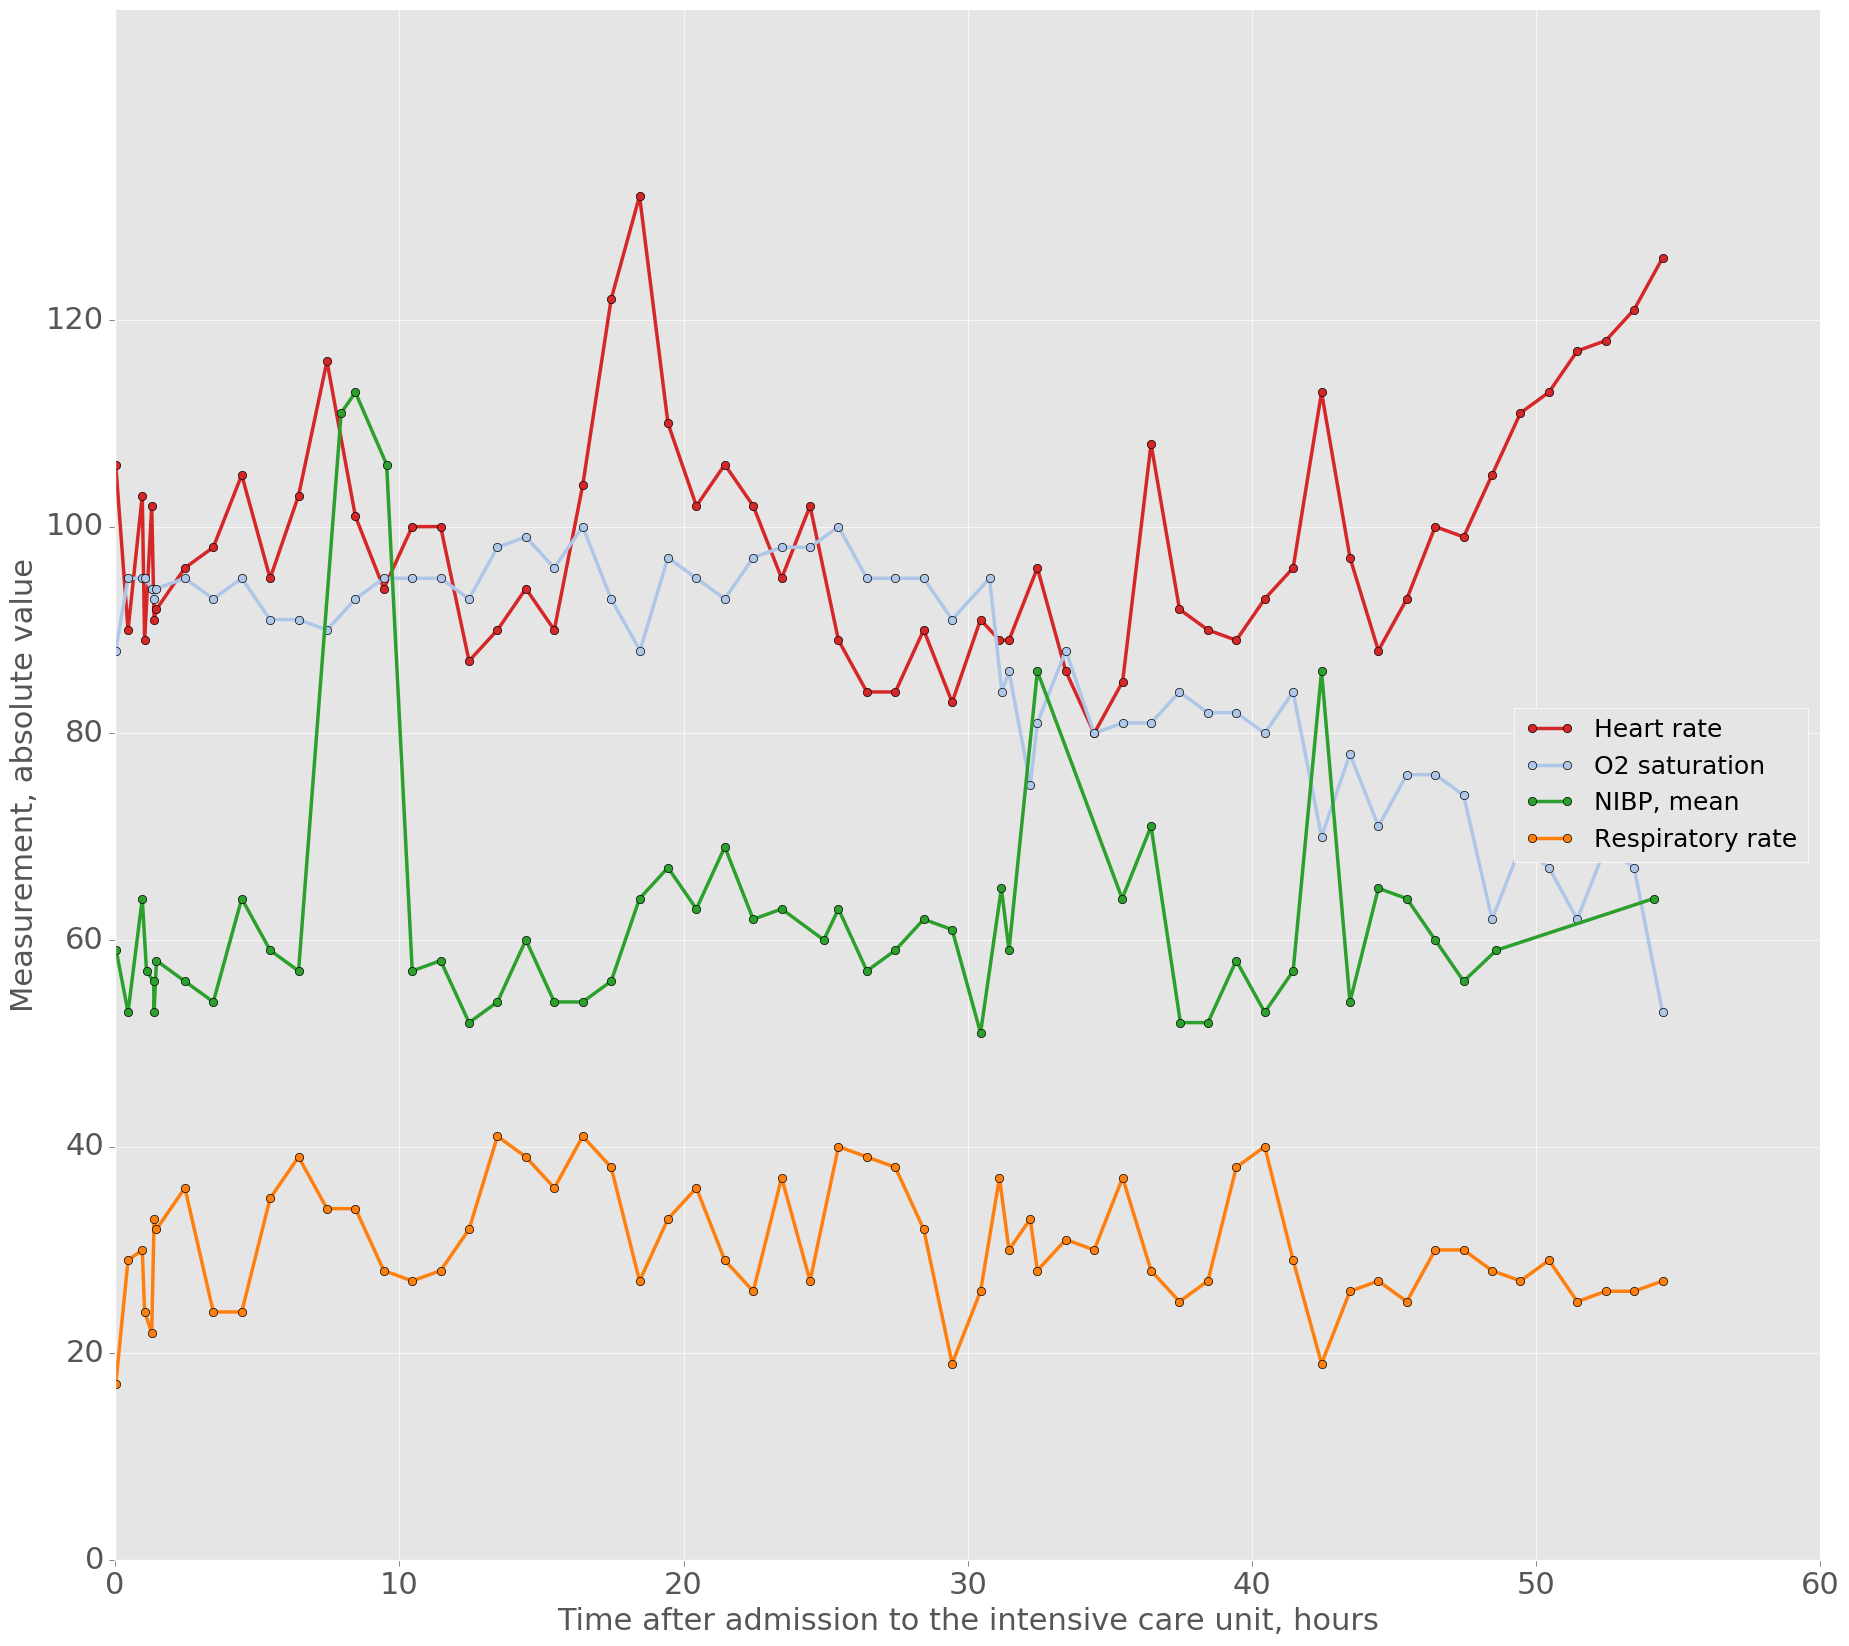

In [197]:
# Credit: Randal Olson for styling (http://www.randalolson.com/2014/06/28/)

# Prepare the size of the figure
fig = plt.figure(figsize=(22, 20))
plt.rcParams.update({'font.size': 22})

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Remove the plot frame lines. 
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.      
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
ax.axis([0,60,0,150])

# Plot vital signs
plt.plot(charts.icutimehr[charts.label=='Heart Rate'], 
         charts.valuenum[charts.label=='Heart Rate'],
         color=tableau20[6], lw=2.5,
         marker='o', markersize=6, label='Heart rate')

plt.plot(charts.icutimehr[charts.label=='O2 saturation pulseoxymetry'], 
         charts.valuenum[charts.label=='O2 saturation pulseoxymetry'],
         color=tableau20[1], lw=2.5, 
         marker='o', markersize=6, label='O2 saturation')

plt.plot(charts.icutimehr[charts.label=='Non Invasive Blood Pressure mean'], 
         charts.valuenum[charts.label=='Non Invasive Blood Pressure mean'],
         color=tableau20[4], lw=2.5,
         marker='o', markersize=6, label='NIBP, mean')

plt.plot(charts.icutimehr[charts.label=='Respiratory Rate'], 
         charts.valuenum[charts.label=='Respiratory Rate'],
         color=tableau20[2], lw=2.5,
         marker='o', markersize=6, label='Respiratory rate')
        
plt.legend(loc=5,fontsize=18)
plt.xlabel('Time after admission to the intensive care unit, hours', fontsize=22)
plt.ylabel('Measurement, absolute value', fontsize=22)
plt.yticks(np.arange(0, 140, 20))

In [11]:
query = \
"""
with ce as
(
  select adm.hadm_id, adm.subject_id, chart.icustay_id
  , chart.charttime
  , chart.charttime - ie.intime AS icutime
    
  --, min(case when itemid in (211,220045) and valuenum > 0 then valuenum else null end) as HeartRate_Min
  --, max(case when itemid in (211,220045) and valuenum < 300 then valuenum else null end) as HeartRate_Max
	, case when itemid in (211,220045) and valuenum > 0 then valuenum else null end as heartrate
  from admissions adm
  left join chartevents chart
    on adm.hadm_id = chart.hadm_id
    and chart.itemid in
    (
    -- HEART RATE
    211, --"Heart Rate"
    220045 --"Heart Rate"
    )
  left join icustays ie  
  -- match the tables on the patient identifier
  on ie.icustay_id = chart.icustay_id
  -- and require that the observation be made after the patient is admitted to the ICU
  and chart.charttime >= ie.intime
  -- and *before* their admission time + 1 day, i.e. the observation must be made on their first day in the ICU
  and chart.charttime <= ie.intime + interval '1 day'
  and chart.error IS DISTINCT FROM 1
    group by adm.hadm_id, chart.icustay_id, adm.subject_id, chart.charttime, ie.intime, chart.itemid, valuenum
)

select *
from ce
where ce.subject_id = 3;
"""

vitals = pd.read_sql_query(query, con)
vitals.head()

,hadm_id,subject_id,icustay_id,charttime,icutime,heartrate
0,145834,3,211552,2101-10-20 18:45:00,NaT,95.0
1,145834,3,211552,2101-10-20 19:30:00,00:19:49,151.0
2,145834,3,211552,2101-10-20 19:45:00,00:34:49,135.0
3,145834,3,211552,2101-10-20 20:00:00,00:49:49,143.0
4,145834,3,211552,2101-10-20 20:15:00,01:04:49,165.0


In [14]:
min(vitals.heartrate)

64.0

## Visualizations

In [2]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, mortality_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

#query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True) # drop NaNs

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

32290


,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,0,0,0,0,70.826046,0,5,0,62.0,119.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
32286,0,0,0,0,63.893494,0,2,1,60.0,95.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
32287,0,0,0,0,43.594414,0,0,1,58.0,80.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32288,1,1,1,1,86.957864,1,2,1,52.0,68.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
32289,0,0,0,0,77.488270,1,0,1,28.0,74.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


## 3D plot with 3 features

Although we now have a lot of features extracted, let's inspect how they might have an impact on mortality prediction. We'll use a 3D scatter plot to visualize age, heartrate and the Glasgow Coma Scale of patients.

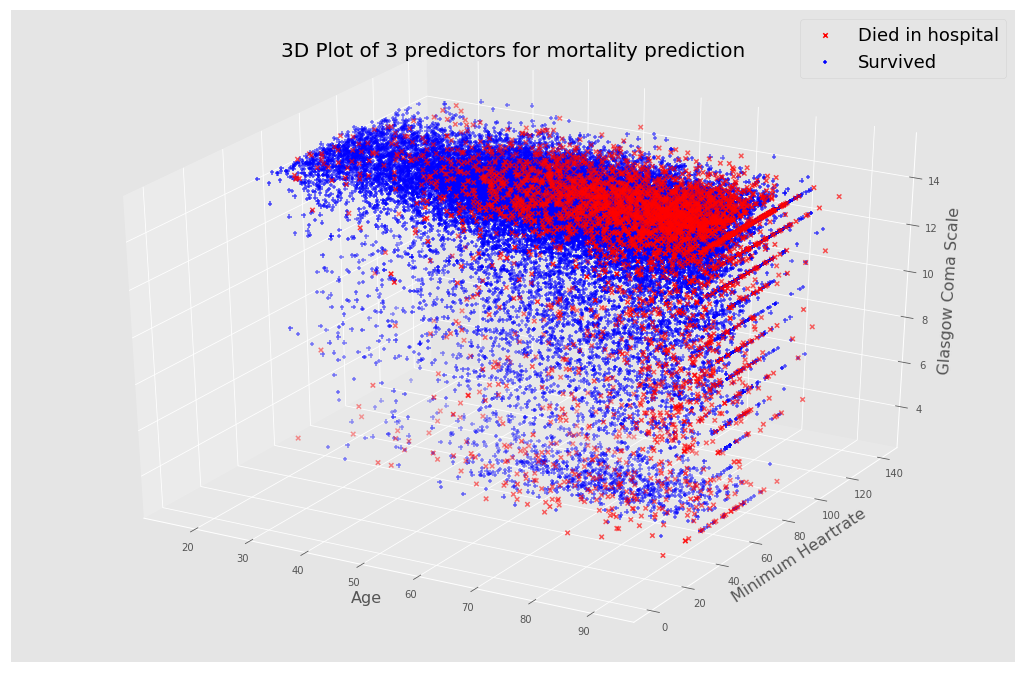

In [3]:
from mpl_toolkits.mplot3d import Axes3D

non_survival = query_output.loc[query_output.hospital_expire_flag == 1, ['age_icu_in', 'heartrate_min', 'mingcs', ]]
survival = query_output.loc[query_output.hospital_expire_flag == 0, ['age_icu_in', 'heartrate_min', 'mingcs', ]]

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(non_survival.loc[:, non_survival.columns[0]], non_survival.loc[:, non_survival.columns[1]], 
           non_survival.loc[:, non_survival.columns[2]], c='red', marker='x', cmap='coolwarm', label='Died in hospital')
ax.scatter(survival.loc[:, survival.columns[0]], survival.loc[:, survival.columns[1]], 
           survival.loc[:, survival.columns[2]], c='blue', marker='+', cmap='coolwarm', label='Survived')

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Minimum Heartrate', fontsize=16)
ax.set_zlabel('Glasgow Coma Scale', fontsize=16)

ax.legend(loc='upper right', fontsize=18)
ax.set_title('3D Plot of 3 predictors for mortality prediction', fontsize=20)

plt.show()

## First lab measurement visualization

To get a better idea of how laboratory measurements for patients admitted to the ICU, we'll plot the distribution of measurements for survival and non-survival groups for various lab measurements. Normal range for the lab measurements can be seen below which have a lower and upper limit, taken from this [notebook](https://github.com/MIT-LCP/mimic-code/blob/master/notebooks/first_labs.ipynb). 

| Lab Value      | Lower limit | Upper Limit | Units  |
|----------------|-------------|-------------|--------|
| Bicarbonate    | 22          | 32          | mEq/L  |
| BUN            | 6           | 20          | mEq/L  |
| Calcium        | 8.4         | 10.3        | mg/dL  |
| Chloride       | 96          | 108         | mEq/L  |
| Creatinine     | 0.4         | 1.1         | mEq/L  |
| Hemoglobin     | 11.2        | 15.7        | g/dL   |
| Lactate        | 0.5         | 2           | mmol/L |
| Magnesium      | 1.6         | 2.6         | mg/dL  |
| Phosphate      | 2.7         | 4.5         | mg/dL  |
| Platelet count | 150         | 400         | K/uL   |
| Potassium      | 3.3         | 5.1         | mEq/L  |
| Sodium         | 133         | 145         | mEq/L  |

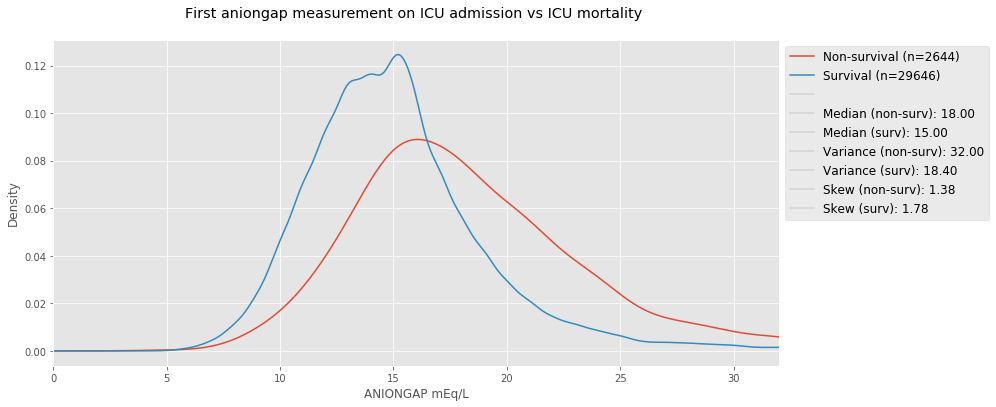

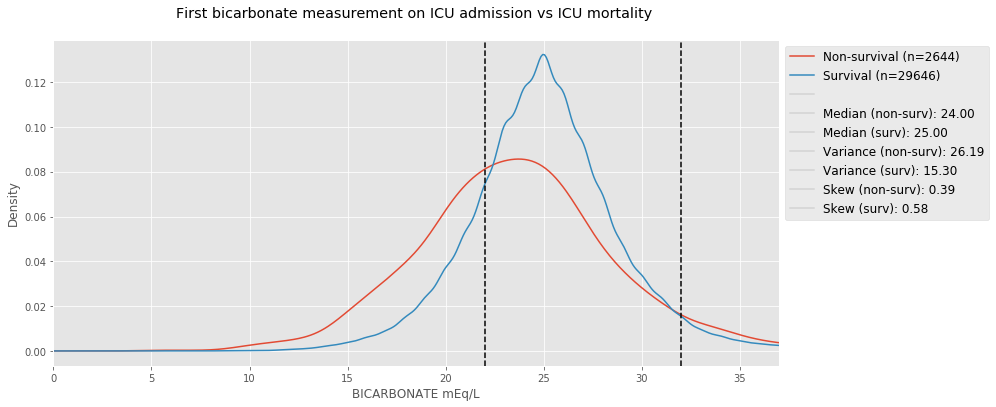

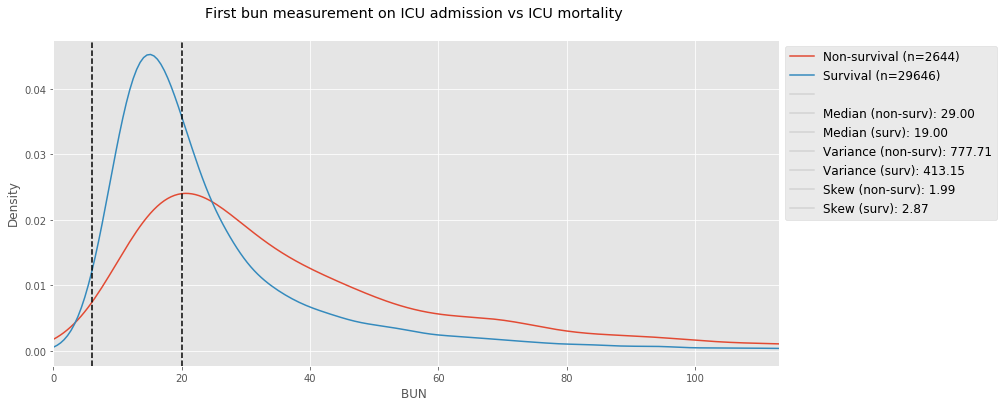

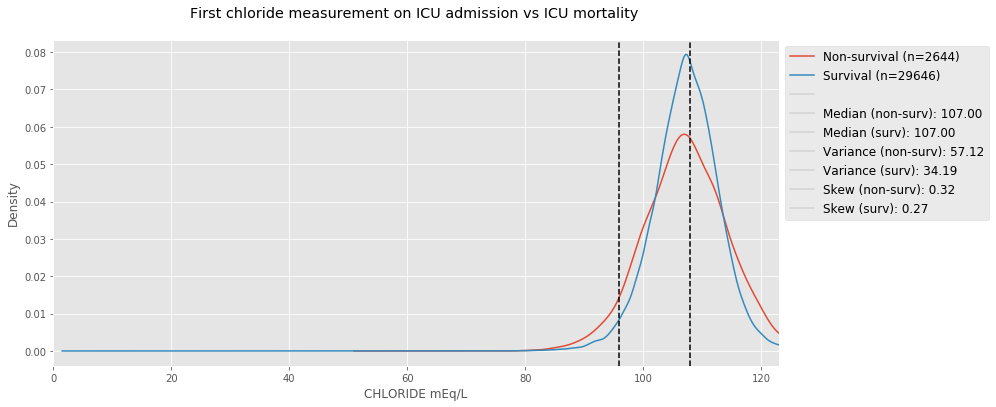

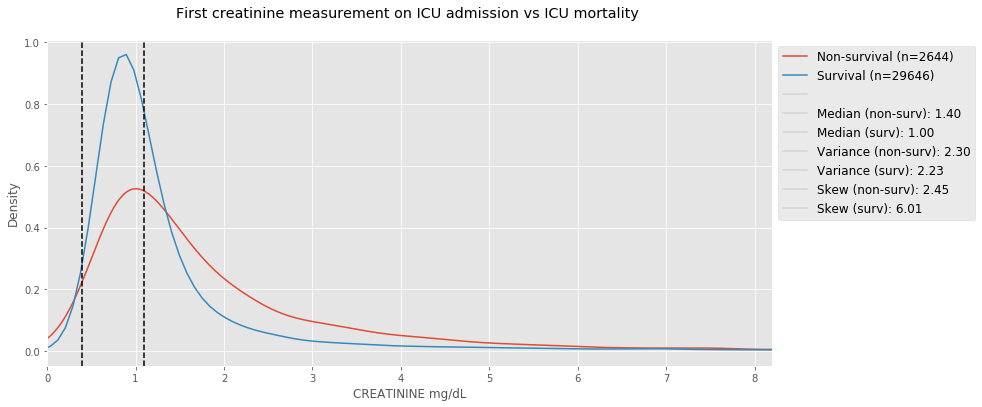

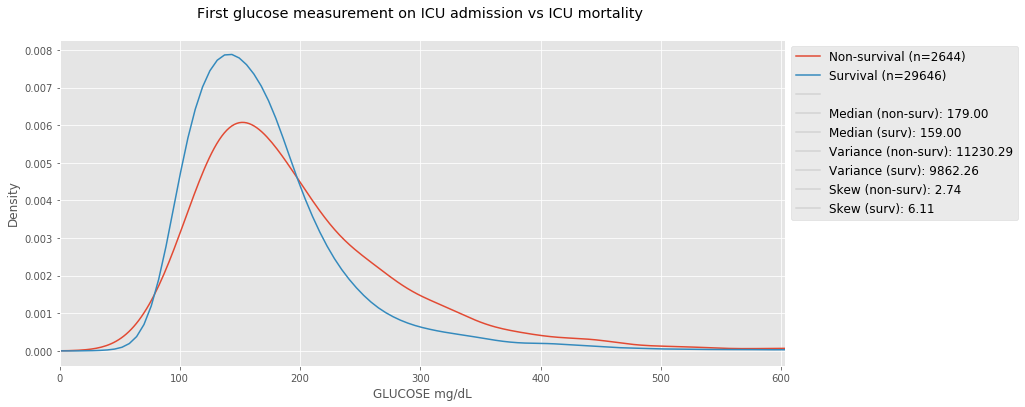

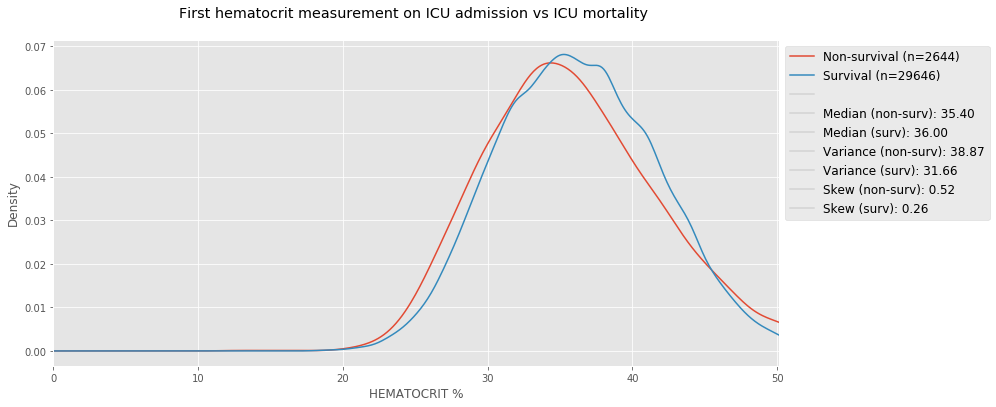

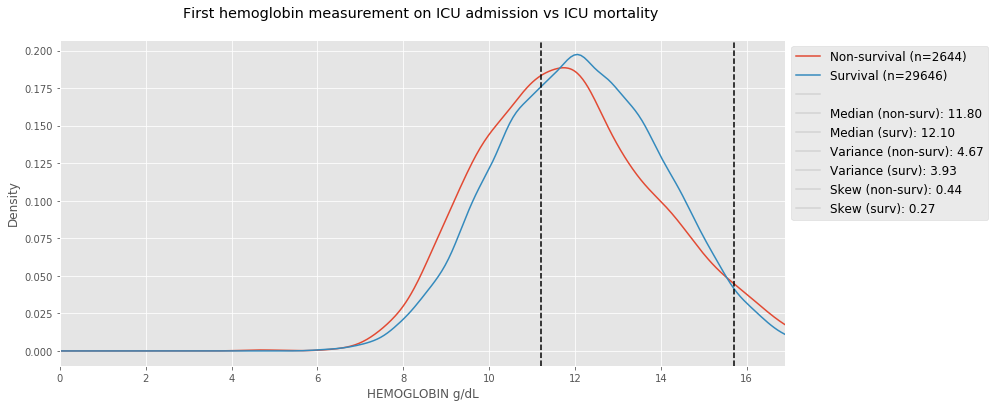

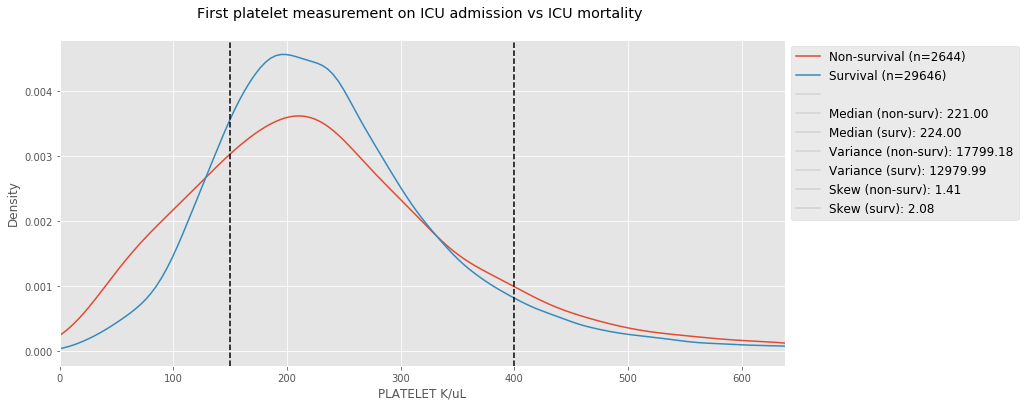

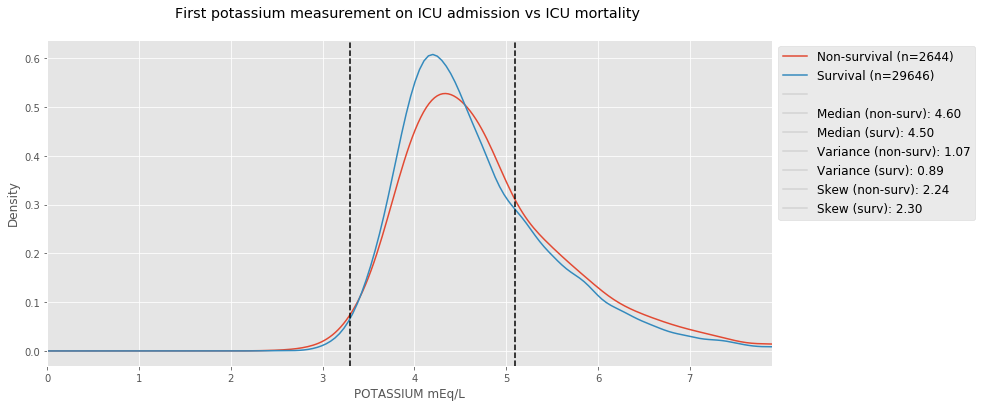

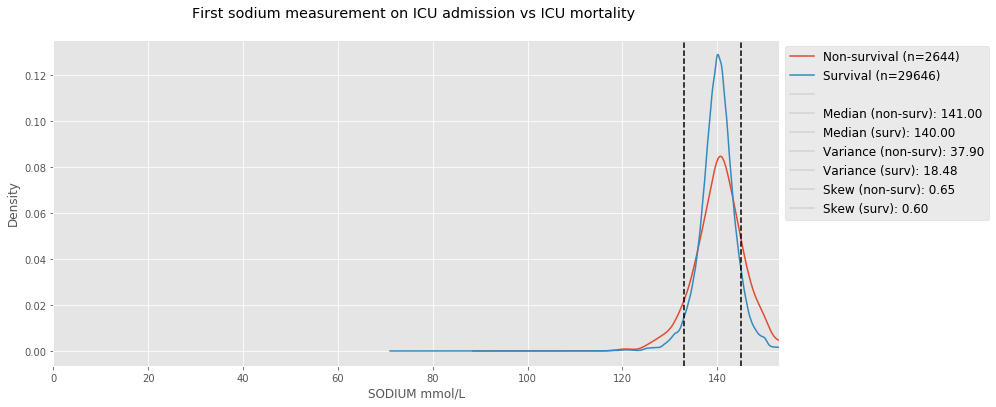

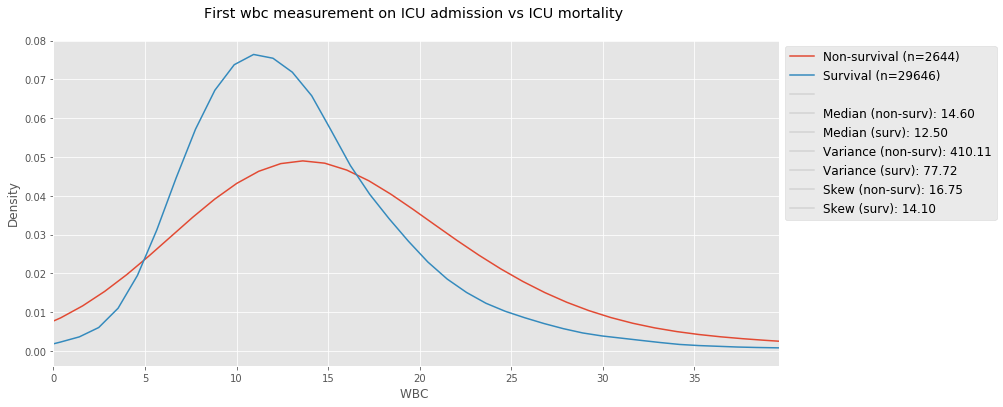

In [11]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }

labs = {'ANIONGAP': 'mEq/L',
        #'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        #'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        #'INR': '',
        #'LACTATE': 'mmol/L',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        #'PT': '',
        #'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

data = query_output

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().count()
    n_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().median()
    med_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().median()
    var_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().var()
    var_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().skew()
    skew_surv = data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().skew() 
    
    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_max'][data.icu_expire_flag==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_max'][data.icu_expire_flag==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_max'].quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## References

1. Ross, M. K., Wei Wei, and L. Ohno-Machado. "“Big data” and the electronic health record." Yearbook of medical informatics 9.1 (2014): 97.

2. Johnson, Alistair EW, et al. "MIMIC-III, a freely accessible critical care database." Scientific data 3 (2016).